In [28]:
import numpy as np
import nibabel as nib
import os
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random

scaler = MinMaxScaler()

# Methods for fetching Nii (NIfTI) files and loading images

In [4]:
# Make sure to change all relevant paths to your own directory the repo is saved in :)
# These functions are relevant for fetching and loading images in case you wish to perform your own npy generated files
def getNiiFiles(base_filename, path):
    nii_files = []
    for root, _, files in os.walk(path):
        subfolder_name = os.path.basename(root)
        for file in files:
            if file.endswith(f'{base_filename}.nii') and not file.endswith(f'{base_filename}.nii.gz'):
                nii_files.append(path + subfolder_name + '/' + file)
    return nii_files

def load_and_transform_img(img_path):
    # Load the image data from the file
    img_data = nib.load(img_path).get_fdata()

    # Reshape, scale and then reshape back to original shape
    transformed_data = scaler.fit_transform(img_data.reshape(-1, img_data.shape[-1])).reshape(img_data.shape)

    return transformed_data

In [5]:
# Get image lists
train_path = 'D:\Skrivebord\BRATS\MICCAI_BraTS2020_TrainingData'
validation_path = 'D:\Skrivebord\BRATS\Validation'
t2_list = getNiiFiles('t2', train_path)
# Grab t1ce files over t1 files, as it has better contrast compared to t2 and flair.
# Refer to https://www.researchgate.net/figure/The-T1-T2-and-T1c-magnetic-resonance-imaging-MRI-sequences-of-4-patients-with-their_fig1_345780641 for more information.
t1ce_list = getNiiFiles('t1ce', train_path)
flair_list = getNiiFiles('flair', train_path)
mask_list = getNiiFiles('seg', train_path)

# Remember to change the path above in case you want to fetch Validation files!

def generate_npy(folder):
    for img in range(len(flair_list)):
        print('Now preparing image and masks number: ', img)

        temp_t2 = load_and_transform_img(t2_list[img])

        temp_t1ce = load_and_transform_img(t1ce_list[img])

        temp_flair = load_and_transform_img(flair_list[img])

        temp_mask=nib.load(mask_list[img]).get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

        combined_images = np.stack([temp_flair, temp_t1ce, temp_t2], axis=3)

        # Transform data to remove a lot of background while keeping interesting pixels in the image, this results in 128x128x128x3 dimensions
        combined_images = combined_images[56:184, 56:184, 13:141]
        temp_mask = temp_mask[56:184, 56:184, 13:141]
        
        temp_mask= to_categorical(temp_mask, num_classes = 4)
        if folder.lower().contains('train'):
            np.save('D:\Skrivebord\BRATS\\npy files\images/image_'+str(img)+'.npy', combined_images)
            np.save('D:\Skrivebord\BRATS\\npy files\masks/mask_'+str(img)+'.npy', temp_mask)
        elif folder.lower().contains('vali'):
            np.save('D:\Skrivebord\BRATS\\npy files\images/image_'+str(img)+'.npy', combined_images)
            np.save('D:\Skrivebord\BRATS\\npy files validation\masks/mask_'+str(img)+'.npy', temp_mask)
        else:
            print("Please include a string containing either 'train' or 'vali'")
            return
        

# Image generators for training the keras model

In [33]:
def fetch_and_process_images(directory, filenames):
    def process_image(file):
        return np.load(directory + file) if file.endswith('.npy') else None

    processed_images = [process_image(f) for f in filenames if process_image(f) is not None]
    return np.stack(processed_images)

def batched_image_mask_generator(image_path, image_files, mask_path, mask_files, size_of_batch):
    total_images = len(image_files)

    def get_batch(slice_start, slice_end):
        image_batch = fetch_and_process_images(image_path, image_files[slice_start:slice_end])
        mask_batch = fetch_and_process_images(mask_path, mask_files[slice_start:slice_end])
        return image_batch, mask_batch

    start, end = 0, size_of_batch
    # Infinite while loop is important for Keras generators
    while True:
        if start >= total_images:
            start, end = 0, size_of_batch
        # Important to yield for it to function as a generator!
        yield get_batch(start, min(end, total_images))
        start, end = end, end + size_of_batch


# Doing some testing

(2, 128, 128, 128, 3)


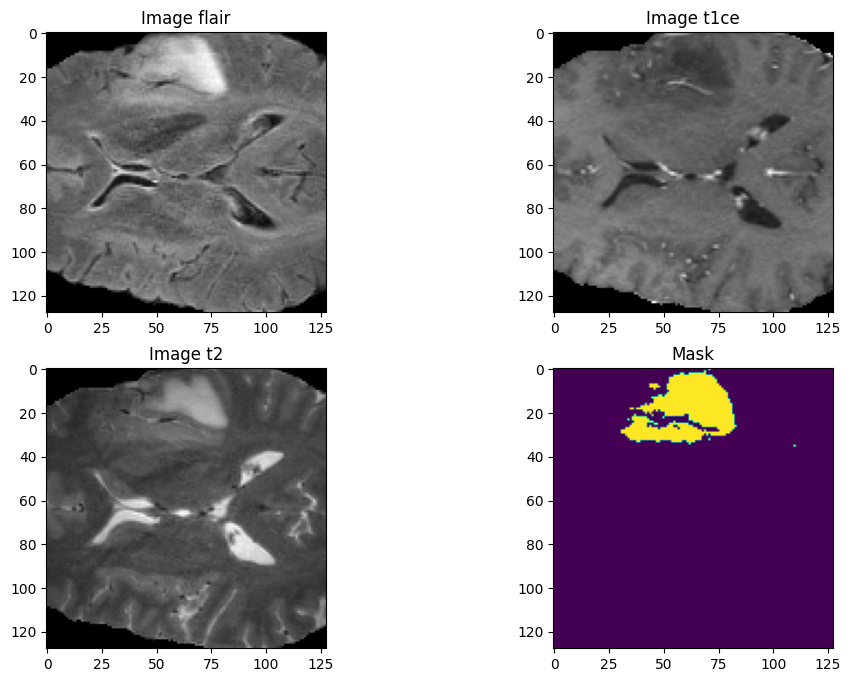

In [34]:
train_img_dir = "D:\Skrivebord\BRATS\\npy files\images\\"
train_mask_dir = "D:\Skrivebord\BRATS\\npy files\masks\\"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = batched_image_mask_generator(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
image, mask = train_img_datagen.__next__()
print(image.shape)

img_num = random.randint(0,image.shape[0]-1)
test_img=image[img_num]
test_mask=mask[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Making the model

In [35]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras.backend as K
kernel_initializer =  'he_uniform'

################################################################
def create_unet_model(height, width, depth, channels, num_classes):
#Build the model
    inputs = Input((height, width, depth, channels))
    s = inputs

    #Contracting path/Encoder 
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
     
    conv3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
     
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
     
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv5)
    
    #Expansive path 
    trans1 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    merge1 = concatenate([trans1, conv4])
    upconv1 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(merge1)
    upconv1 = Dropout(0.2)(upconv1)
    upconv1 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(upconv1)
     
    trans2 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(upconv1)
    merge2 = concatenate([trans2, conv3])
    upconv2 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(merge2)
    upconv2 = Dropout(0.2)(upconv2)
    upconv2 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(upconv2)
     
    trans3 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(upconv2)
    merge3 = concatenate([trans3, conv2])
    upconv3 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(merge3)
    upconv3 = Dropout(0.1)(upconv3)
    upconv3 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(upconv3)
     
    trans4 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(upconv3)
    merge4 = concatenate([trans4, conv1])
    upconv4 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(merge4)
    upconv4 = Dropout(0.1)(upconv4)
    upconv4 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(upconv4)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(upconv4)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Test model functioning 
model = create_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


# Pre training

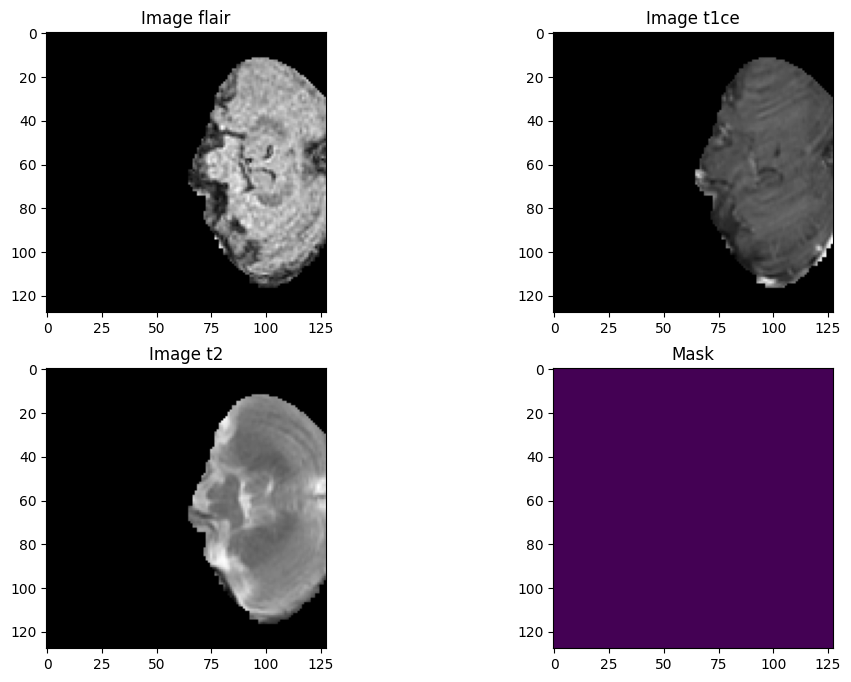

In [36]:
train_img_dir = "D:\Skrivebord\BRATS\\npy files\images\\"
train_mask_dir = "D:\Skrivebord\BRATS\\npy files\masks\\"

list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Define the image generators for training and validation

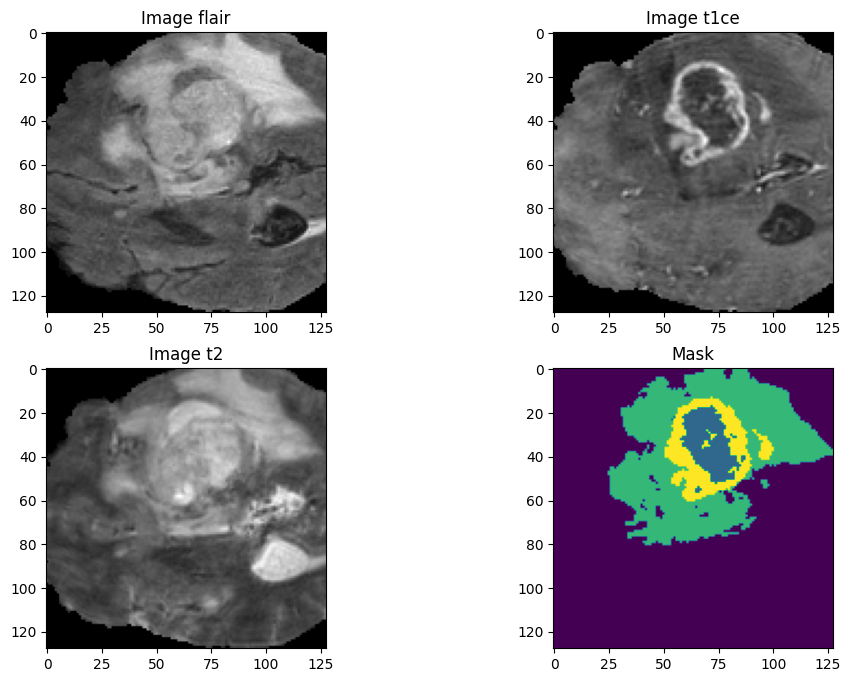

In [10]:
train_img_dir = "D:\Skrivebord\BRATS\\npy files\images\\"
train_mask_dir = "D:\Skrivebord\BRATS\\npy files\masks\\"

val_img_dir = "D:\Skrivebord\BRATS\\npy files validation\images\\"
val_mask_dir = "D:\Skrivebord\BRATS\\npy files validation\masks\\"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = batched_image_mask_generator(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = batched_image_mask_generator(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

image, mask = train_img_datagen.__next__()

img_num = random.randint(0,image.shape[0]-1)
test_img=image[img_num]
test_mask=mask[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
n_slice=55
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Parameters before the model

In [11]:
# Taken from github repo at https://github.com/aldi-dimara/keras-focal-loss, to better show how categorical focal loss functions, for better personal understanding.
#
# Keras.loss has its own CategoricalFocalCrossEntropy at https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy, but we decided the longer self-written
# implementation, for better understanding and analysis.
# Gamma = 2 and alpha = 0.25, as that is standard for focal loss, test other values at your own leisure.
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [37]:
LR = 0.001
optim = Adam(LR)

# Define how many iterations each epoch should have, the most normal being going through each data element once, therefore the number of data elements divided by batch size.
epoch_steps_train = len(train_img_list)//batch_size
epoch_steps_val = len(val_img_list)//batch_size

model = create_unet_model(height=128, 
                          width=128, 
                          depth=128, 
                          channels=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=categorical_focal_loss(gamma=2.0, alpha=0.25), metrics=MeanIoU(num_classes=4))
#print(model.summary())

print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [23]:
# This is how to load a model, if one has previously saved the model (there are files that we have saved available), remember the choose the right path
# model = keras.models.load_model('<yourpathhere>\BRATS\Models\model_newBase_60epochs.keras', custom_objects={'focal_loss': categorical_focal_loss(gamma=2.0, alpha=0.25)})

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=epoch_steps_train,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=epoch_steps_val,
          )

Epoch 1/5


145/145 [==============================] - 560s 4s/step - loss: 0.7157 - accuracy: 0.9562 - val_loss: 0.9136 - val_accuracy: 0.9476
Epoch 2/5
145/145 [==============================] - 559s 4s/step - loss: 0.7105 - accuracy: 0.9562 - val_loss: 0.9043 - val_accuracy: 0.9481
Epoch 3/5
145/145 [==============================] - 557s 4s/step - loss: 0.7074 - accuracy: 0.9562 - val_loss: 0.9090 - val_accuracy: 0.9481
Epoch 4/5
145/145 [==============================] - 546s 4s/step - loss: 0.7058 - accuracy: 0.9562 - val_loss: 0.9003 - val_accuracy: 0.9481
Epoch 5/5
145/145 [==============================] - 559s 4s/step - loss: 0.7019 - accuracy: 0.9562 - val_loss: 0.9201 - val_accuracy: 0.9481


# Plot the training and validation IoU and loss at each epoch

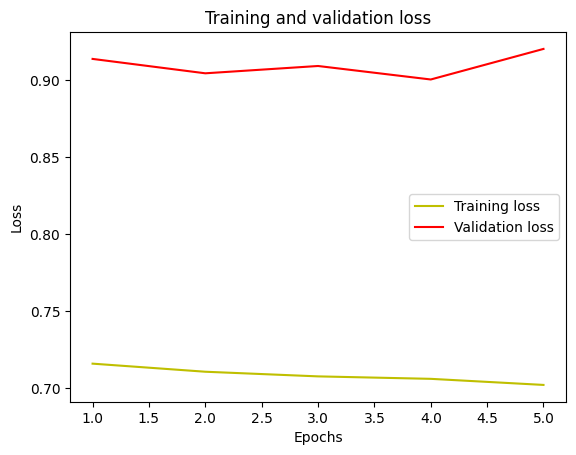

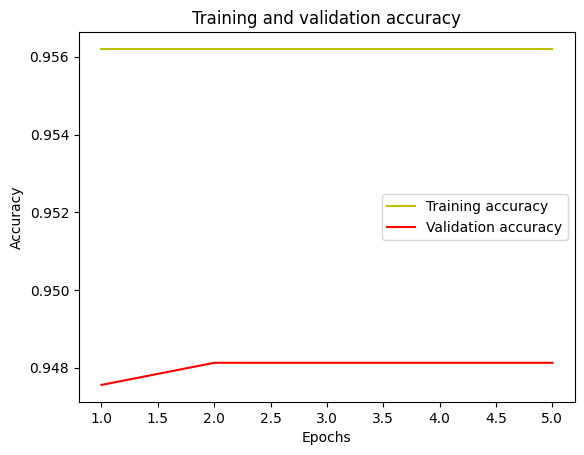

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Verify IuO on a Batch of images from the test dataset

In [24]:
# Using built in keras function for IoU
# Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 # Check IoU for a batch of images
test_img_datagen = batched_image_mask_generator(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 4s 4s/step
Mean IoU = 0.28231487


# Predict a single image so we can plot it and compare differences to ground truth mask

In [25]:
# Try images: 
img_num = 40

test_img = np.load("D:\Skrivebord\BRATS\\npy files validation\images/image_"+str(img_num)+".npy")

test_mask = np.load("D:\Skrivebord\BRATS\\npy files validation\masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 446ms/step


# Plot the predicted images mask, flair, and prediction mask

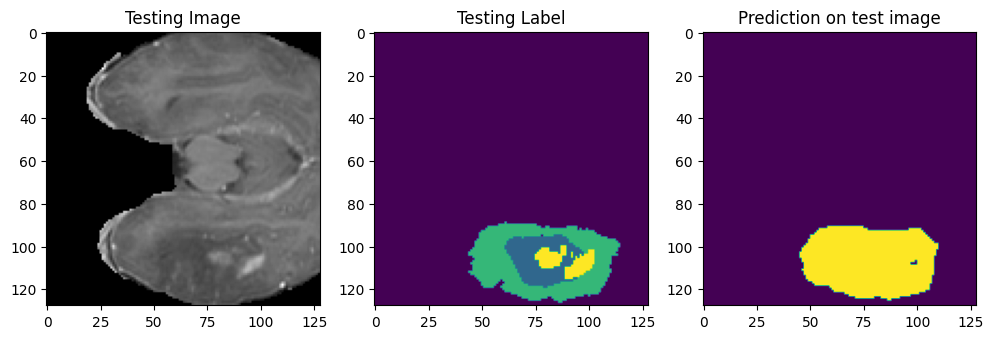

In [26]:
n_slice = 36
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


In [ ]:
# This is how you save your model after training, if you wish to do so.
model.save('D:\Skrivebord\BRATS\Models\model_DataAug_65epochs.keras')